# Audio Classifier

This project uses the **ESC-50 audio dataset**, a well-known dataset for environmental sound classification, sourced from **freesound.org**. The project uses the machine learning techniques of **Random Forests**, **Support Vector Machines (SVM)**, and **Recurrent Neural Network with Long Short-Term Memory (RNN-LSTM)** to classify sounds from the dataset.

- For the **Random Forest** and **SVM** models, I preprocess the data by extracting the **Mel Frequency Cepstral Coefficients (MFCCs)** and collapsing them into a row/column vector.
- For the **RNN-LSTM**, the data is processed separately due to the complex input requirements, involving interleaved **MFCCs**, **delta MFCCs**, and **delta-delta MFCCs** to handle the 3D input shape.

The dataset can be accessed [here](https://github.com/karolpiczak/ESC-50).

K. J. Piczak. ESC: Dataset for Environmental Sound Classification. Proceedings of the 23rd Annual ACM Conference on Multimedia, Brisbane, Australia, 2015.

[DOI: http://dx.doi.org/10.1145/2733373.2806390]

In [10]:
import csv # used for reading data from csvs, specifically for workarounds to make my RNN-LSTM work
import os # used to read, manage, and process files from my computer
import shutil # used to copy the contents of one folder to another. This was another part of my RNN-LSTM workaround
import json # used for the RNN-LSTM to format the data in a way that finally worked
import numpy as np # used for certain matrix, vector, and general math computations when needed
import random # used occasionally when a variable or parameter needed to be assigned a random value
from sklearn.model_selection import train_test_split # used to split the data into a train and test set for SVM and Random Forest
import tensorflow.keras as keras # used for implementing the RNN-LSTM model
import matplotlib.pyplot as plt # used for plotting accuracy and loss
import librosa # used for extracting MFCCs and delta MFCCs
import math # used for miscellaneous math functions
import pandas as pd # used for reading csvs and creating dataframes
from sklearn.model_selection import RandomizedSearchCV # used for tweaking the hyper parameters of SVM and Random Forest
from scipy.stats import expon, randint, uniform # used for tweaking parameters in the RandomizedSearch parameter list
from sklearn.ensemble import RandomForestClassifier # used to implement Random Forest
from sklearn.svm import SVC # used to implement SVC
from sklearn.metrics import accuracy_score, classification_report # used to receive basic feedback about model performance
import requests
import zipfile

GITHUB_DATASET_URL = "https://github.com/karolpiczak/ESC-50/archive/master.zip"
DATASET_ZIP = "ESC-50.zip"
DATASET_DIR = "ESC-50"

def download_dataset():
    if not os.path.exists(DATASET_ZIP):
        print(f"Downloading {GITHUB_DATASET_URL}...")
        response = requests.get(GITHUB_DATASET_URL, stream=True)
        with open(DATASET_ZIP, 'wb') as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print(f"Dataset downloaded and saved as {DATASET_ZIP}.")
    else:
        print(f"{DATASET_ZIP} already exists.")

def extract_dataset():
    if not os.path.exists(DATASET_DIR):
        print(f"Extracting {DATASET_ZIP}...")
        with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
            zip_ref.extractall(".")
        print(f"Dataset extracted to {DATASET_DIR}.")
    else:
        print(f"{DATASET_DIR} already exists.")

download_dataset()
extract_dataset()

CSV_PATH = "ESC-50-master/meta/esc50.csv"
AUDIO_PATH = "ESC-50-master/audio"

def extract_features(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13*8)
    mfccs_processed = np.mean(mfccs.T, axis=0)
    return mfccs_processed


DATA = pd.read_csv(CSV_PATH)
DATA['mfccs'] = DATA['filename'].apply(lambda x: extract_features(os.path.join(AUDIO_PATH, x)))
    
NON_DEEP_INPUTS = np.array(DATA['mfccs'].tolist())
NON_DEEP_TARGETS = DATA['target'].values

INDICES = np.arange(DATA.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    NON_DEEP_INPUTS, NON_DEEP_TARGETS, INDICES, 
    test_size=0.2, 
    random_state=42
)


Dataset downloaded and saved as ESC-50.zip.
Extracting ESC-50.zip...
Dataset extracted to ESC-50.


## Random Forest

I used Random Forest as an ensemble method to help mitigate overfitting. Random Forest works by constructing multiple decision trees, each trained on different random subsets of the data, and by selecting a random subset of features at each split. This randomness ensures that the model is robust and reduces the likelihood of any single tree dominating the overall predictions. I optimized the hyperparameters using a random search, and once I found a configuration that outperformed manual tuning, I implemented it and commented out the hyperparameter tuning processs.

In [11]:
random_forest = RandomForestClassifier(
    bootstrap=True, 
    max_depth=23, 
    max_features='log2', 
    min_samples_leaf=1, 
    min_samples_split=6, 
    n_estimators=191, 
    random_state=42
)
    
random_forest.fit(X_train, y_train)

rf_y_train_pred = random_forest.predict(X_train)
rf_y_test_pred = random_forest.predict(X_test)

rf_train_accuracy = accuracy_score(y_train, rf_y_train_pred)
rf_test_accuracy = accuracy_score(y_test, rf_y_test_pred)

print(f"Training Accuracy: {rf_train_accuracy}")
print(f"Test Accuracy: {rf_test_accuracy}\n")
    
# print random audio file and its classification
random_idx = random.randint(0, len(X_test) - 1)
random_index = idx_test[random_idx]
random_audio_filename = DATA.iloc[random_index]['filename']
actual_class = NON_DEEP_TARGETS[random_index]
predicted_class = rf_y_test_pred[random_idx]
print(f"Random Audio File: {random_audio_filename}")
print(f"Actual Label: {actual_class}")
print(f"Predicted Label: {predicted_class}")

# hyperparameter tuning
#param_distributions = {
#    'n_estimators': randint(50, 200),
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth': randint(10, 50),
#    'min_samples_split': randint(2, 10),
#    'min_samples_leaf': randint(1, 10),
#    'bootstrap': [True, False]
#}

# used for finding best hyperparameters   
#random_search = RandomizedSearchCV(
#    rf_clf, param_distributions, 
#    n_iter=50, 
#    cv=5, 
#    verbose=3, 
#    random_state=42, 
#    n_jobs=-1
#)
#random_search.fit(X_train, y_train)

#print("Best parameters found:", random_search.best_params_)
#print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

#best_model = random_search.best_estimator_
#test_accuracy = best_model.score(X_test, y_test)
#print("Test set accuracy: {:.2f}".format(test_accuracy))

%time

Training Accuracy: 1.0
Test Accuracy: 0.46

Random Audio File: 5-187444-A-33.wav
Actual Label: 33
Predicted Label: 10
CPU times: user 2 µs, sys: 2 µs, total: 4 µs
Wall time: 6.91 µs


## Support Vector Machine

I chose to use Support Vector Machines (SVM). My goal was to compare SVMs, known for their universal approximation capabilities, with the next algorithm which is a neural network. Although SVMs are often associated with linearly separable data and binary classification, Scikit-Learn’s implementation supports multiclass classification by default. Similar to Random Forest, I achieved better results by increasing the number of MFCCs during feature extraction and using random search to optimize hyperparameters beyond manual tuning.


In [12]:
svm = SVC(
    C=46.97965779202672, 
    coef0=2.4242424242424243, 
    degree=5, 
    gamma='scale', 
    kernel='poly', 
    tol=0.0033028701062519108
)
svm.fit(X_train, y_train)

svm_y_train_pred = svm.predict(X_train)
svm_y_test_pred = svm.predict(X_test)

svm_train_accuracy = accuracy_score(y_train, svm_y_train_pred)
svm_test_accuracy = accuracy_score(y_test, svm_y_test_pred)

print(f"Training Accuracy: {svm_train_accuracy}")
print(f"Test Accuracy: {svm_test_accuracy}\n")
    
random_idx = random.randint(0, len(X_test) - 1)
random_index = idx_test[random_idx]
random_audio_filename = DATA.iloc[random_index]['filename']
actual_class = NON_DEEP_TARGETS[random_index]
predicted_class = svm_y_test_pred[random_idx]
print(f"Random Audio File: {random_audio_filename}")
print(f"Actual Label: {actual_class}")
print(f"Predicted Label: {predicted_class}")

# hyperparameter tuning
#param_distributions = {
#    'C': expon(scale=100),  
#    'kernel': ['rbf', 'poly'],
#    'gamma': ['scale', 'auto'] + list(np.logspace(-9, 3, 13)),
#    'degree': randint(2, 5),
#    'coef0': np.linspace(0, 10, 100),
#    'tol': expon(scale=0.001)
#}

#random_search = RandomizedSearchCV(
#    svm, param_distributions, 
#    n_iter=50, 
#    cv=5, 
#    verbose=3, 
#    random_state=42, 
#    n_jobs=-1
#)
#random_search.fit(X_train, y_train)

#print("Best parameters found:", random_search.best_params_)
#print("Best cross-validation score: {:.2f}".format(random_search.best_score_))

#best_model = random_search.best_estimator_
#test_accuracy = best_model.score(X_test, y_test)
#print("Test set accuracy: {:.2f}".format(test_accuracy))

%time

Training Accuracy: 1.0
Test Accuracy: 0.475

Random Audio File: 2-157488-A-6.wav
Actual Label: 6
Predicted Label: 6
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


## Recurrent Neural Network with Long Short-Term Memory (RNN-LSTM)

The final algorithm used was an RNN-LSTM, which outperformed the other models but required significantly more computational resources. I selected RNN-LSTM for its ability to handle time-series data more effectively than other neural network architectures, with LSTMs specifically addressing the vanishing/exploding gradient problem. Key factors such as batch size, number of MFCCs, number of layers, and optimizer choice were critical in tuning the model for optimal performance.


creating new directory...
done.

creating .json...

done.



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 22, 512)        │     1,689,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,077,106 (15.55 MB)

 Trainable params: 4,077,106 (15.55 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 971ms/step - accuracy: 0.0940 - loss: 3.6978 - val_accuracy: 0.2997 - val_loss: 2.5708
Epoch 2/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 953ms/step - accuracy: 0.3391 - loss: 2.3607 - val_accuracy: 0.4243 - val_loss: 2.0552
Epoch 3/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 948ms/step - accuracy: 0.4839 - loss: 1.8200 - val_accuracy: 0.5040 - val_loss: 1.7613
Epoch 4/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 949ms/step - accuracy: 0.5959 - loss: 1.4296 - val_accuracy: 0.5437 - val_loss: 1.6045
Epoch 5/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 950ms/step - accuracy: 0.6489 - loss: 1.2273 - val_accuracy: 0.5777 - val_loss: 1.5193
Epoch 6/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 951ms/step - accuracy: 0.6957 - loss: 1.0611 - val_accuracy: 0.6247 - val_loss: 1.4055
Epoch 7/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 957ms/step - accuracy: 0.7478 - loss: 0.8862 - val_accuracy: 0.6420 - val_loss: 1.3418
Epoch 8/30
24/24 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.7756 - loss: 0.7886 - val_accurac

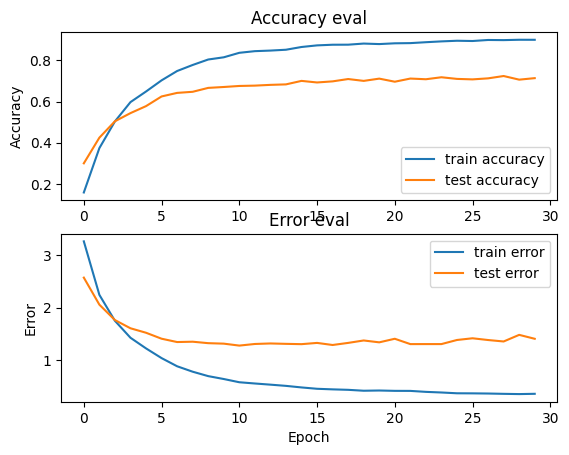

157/157 - 9s - 55ms/step - accuracy: 0.7204 - loss: 1.3888

Test accuracy: 0.7203999757766724
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
True label: 15, Predicted label: [38]
CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 11.2 µs


In [13]:
def organize_audio_files(csv_file_path, audio_files_directory, organized_directory):
    os.makedirs(organized_directory, exist_ok=True)
    print("creating new directory...")
    with open(csv_file_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header
        for row in reader:
            file_name, label = row[0], row[3]

            label_directory = os.path.join(organized_directory, label)
            os.makedirs(label_directory, exist_ok=True)

            source_path = os.path.join(audio_files_directory, file_name)
            destination_path = os.path.join(label_directory, file_name)

            if os.path.exists(destination_path):
                os.remove(destination_path)
            shutil.copy2(source_path, destination_path)
            #print(f"Copied {file_name} to {label_directory}/")

    print("done.\n")

def create_json(dataset_path, json_path, n_mfcc=13*8, n_fft=2048, hop_length=512, num_segments=5, sample_rate=22050, duration=5):
    print("creating .json...\n")
    samples_per_track = sample_rate * duration

    data = {
        "mapping": [],
        "mfcc": [],
        "labels": []
    }

    num_samples_per_segment = int(samples_per_track / num_segments)
    expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if '.ipynb_checkpoints' in dirnames:
            dirnames.remove('.ipynb_checkpoints')

        if dirpath != dataset_path:
            dirpath_components = dirpath.split("/")
            semantic_label = dirpath_components[-1]
            if semantic_label != "genres_original":
                data["mapping"].append(semantic_label)

                for f in filenames:
                    if not f.lower().endswith('.wav'):
                        continue

                    file_path = os.path.join(dirpath, f)
                    try:
                        signal, sr = librosa.load(file_path, sr=sample_rate)
                    except Exception as e:
                        print("Error loading {}: {}".format(file_path, e))

                    for s in range(num_segments):
                        start_sample = num_samples_per_segment * s
                        finish_sample = start_sample + num_samples_per_segment

                        mfcc = librosa.feature.mfcc(
                            y=signal[start_sample:finish_sample],
                            sr=sr,
                            n_fft=n_fft,
                            n_mfcc=n_mfcc,
                            hop_length=hop_length
                        )
                        mfcc = mfcc.T
                        delta_mfcc = librosa.feature.delta(mfcc)
                        delta2_mfcc = librosa.feature.delta(mfcc, order=2)

                        combined_mfccs = []
                        for j in range(len(mfcc)):
                            combined_mfccs.append(mfcc[j].tolist() + delta_mfcc[j].tolist() + delta2_mfcc[j].tolist())

                        if len(combined_mfccs) == expected_num_mfcc_vectors_per_segment:
                            data["mfcc"].append(combined_mfccs)
                            data["labels"].append(i-1)

    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)

    print("done.\n")

def load_data(data_path):
    with open(data_path, "r") as filepath:
        data = json.load(filepath)
    inputs = np.array(data["mfcc"])
    targets = np.array(data["labels"])
    return inputs, targets

def prepare_dataset(test_size, validation_size, data_path):

    inputs, targets = load_data(data_path)
    X_train, X_test, y_train, y_test = train_test_split(
        inputs, targets, 
        test_size=test_size
    )
    X_train, X_validation, y_train, y_validation = train_test_split(
        X_train, y_train, 
        test_size=validation_size
    )
    return X_train, X_validation, X_test, y_train, y_validation, y_test

def build_model(input_shape):
    model = keras.Sequential()
    model.add(keras.layers.LSTM(512, input_shape=input_shape, return_sequences=True))
    model.add(keras.layers.LSTM(512))
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(0.1))
    model.add(keras.layers.Dense(50, activation='softmax'))

    return model

def plot_history(history):

    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Error")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

def predict(model, X, y):

    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    print("True label: {}, Predicted label: {}".format(y, predicted_index))


rnn_data = 'NEW_ESC-50'
organize_audio_files(CSV_PATH, AUDIO_PATH, rnn_data)
rnn_json = "ESC-50_deltas.json"
create_json(rnn_data, rnn_json, num_segments=10)

X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_dataset(0.25, 0.2, rnn_json)

input_shape = (X_train.shape[1], X_train.shape[2])
RNN_LSTM = build_model(input_shape)

optimizer = keras.optimizers.Adamax(learning_rate=0.01)
RNN_LSTM.compile(optimizer=optimizer,
                 loss="sparse_categorical_crossentropy",
                 metrics=['accuracy'])

RNN_LSTM.summary()

history = RNN_LSTM.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=512, epochs=30)

plot_history(history)

test_loss, test_acc = RNN_LSTM.evaluate(X_test, y_test, verbose=2)
print("\nTest accuracy: {}".format(test_acc))
rnn_input = X_test[100]
rnn_target = y_test[100]
predict(RNN_LSTM, rnn_input, rnn_target)

%time

## Results and Analysis

The traditional machine learning algorithms (SVM and Random Forest) didn’t perform as well as the neural network (RNN-LSTM). However, I believe the results could be more conclusive with a more systematic approach, as I encountered difficulties with input data formatting. Additionally, I would like to explore methods for addressing overfitting beyond hyperparameter tuning. Interestingly, in one undocumented run with a toy dataset, the performance surpassed that of the RNN on the full dataset, though I’m unsure why. Similarly, modifying the inclusion of delta and delta-delta MFCCs had little impact, and running models solely on these features resulted in poorer performance. It’s worth noting that the data generated for the traditional models differed from that used in the neural network architecture.


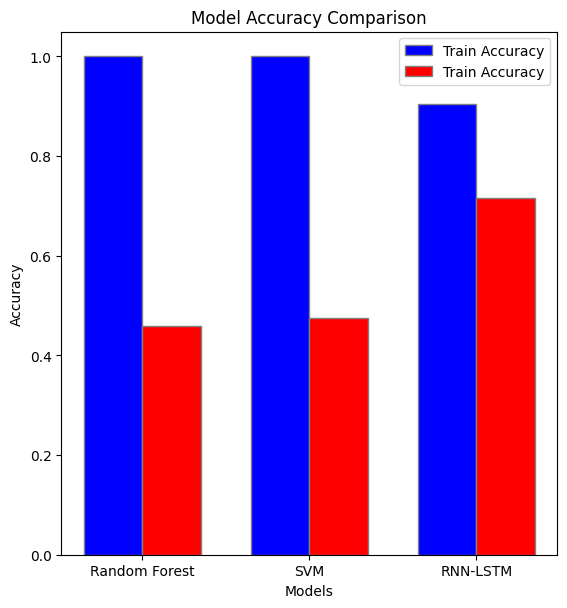

In [14]:
rf_train_accuracy = 1.0
rf_test_accuracy = 0.46

svm_train_accuracy = 1.0
svm_test_accuracy = 0.475

rnn_train_accuracy = 0.9048 
rnn_val_accuracy = 0.7153

models = ['Random Forest', 'SVM', 'RNN-LSTM']
train_accuracies = [rf_train_accuracy, svm_train_accuracy, rnn_train_accuracy]
test_accuracies  = [rf_test_accuracy, svm_test_accuracy, rnn_val_accuracy]

bar_width = 0.35
r1 = np.arange(len(models))
r2 = [x + bar_width for x in r1]

fig, ax = plt.subplots()

ax.bar(r1, train_accuracies, color='b', width=bar_width, edgecolor='grey', label='Train Accuracy')
ax.bar(r2, test_accuracies, color='r', width=bar_width, edgecolor='grey', label='Train Accuracy')

ax.set_xlabel('Models')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracy Comparison')
ax.set_xticks([r + bar_width/2 for r in range(len(models))])
ax.set_xticklabels(models)

ax.legend()
plt.subplots_adjust(top=1.2)
plt.show()


# Optional Cleanup Cell

Run this cell if you want to delete the downloaded and processed files.

In [15]:
ESC_50_MASTER_DIR = "ESC-50-master"
NEW_ESC_50_DIR = "NEW_ESC-50"
ESC_50_DELTAS_JSON = "ESC-50_deltas.json"
ESC_50_ZIP = "ESC-50.zip"

def delete_if_exists(path):
    if os.path.exists(path):
        if os.path.isfile(path):
            os.remove(path)  
            print(f"Deleted file: {path}")
        elif os.path.isdir(path):
            shutil.rmtree(path)  
            print(f"Deleted directory: {path}")

delete_if_exists(ESC_50_MASTER_DIR)  
delete_if_exists(NEW_ESC_50_DIR)     
delete_if_exists(ESC_50_DELTAS_JSON) 
delete_if_exists(ESC_50_ZIP)

print("Cleanup complete. All specified files and directories have been removed.")

Deleted directory: ESC-50-master
Deleted directory: NEW_ESC-50
Deleted file: ESC-50_deltas.json
Deleted file: ESC-50.zip
Cleanup complete. All specified files and directories have been removed.
